In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
df = pd.read_csv('wine_review.csv')
del df["region_2"]
del df['Unnamed: 0']
df = df.dropna()

In [3]:
df.head()

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature


In [4]:
sns.set(style='whitegrid', rc={'figure.figsize' : (10,5)})

In [6]:
# Какие оценки ставят чаще всего

most_common_points = df.groupby('points', as_index=False) \
    .agg({'price': 'count'}) \
    .rename(columns={'price': 'points_count'}) \
    .sort_values('points_count', ascending=False) \
    .head(10)

In [18]:
# Какую оценку в среднем ставят каждой цене

avg_points_for_price = df.groupby('price', as_index=False) \
    .agg({'points': 'mean'}) \
    .rename(columns={'points': 'avg_points'}) \
    .sort_values('avg_points', ascending=False)

In [7]:
# "Дешевые" (ниже 25-го перцентиля) вина с хорошей оценкой

price_q_25 = df.price.quantile(q=0.25)
cheap_and_good = df.query('price < @price_q_25') \
    .groupby(['title', 'price'], as_index=False) \
    .agg({'points': 'mean'}) \
    .sort_values('points', ascending=False) \
    .head(10)

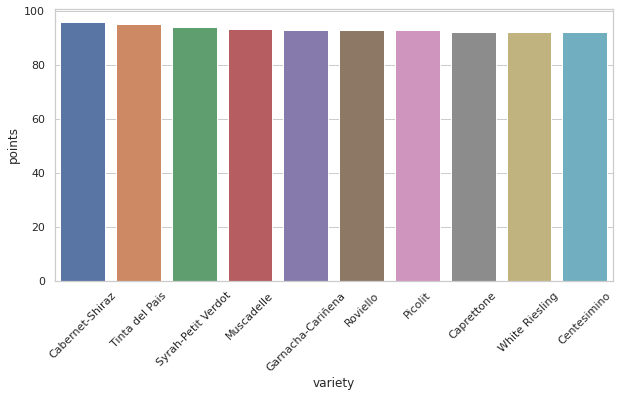

In [8]:
# Лучшие сорта по оценке

top_varieties = df.groupby('variety', as_index=False) \
    .agg({'points': 'mean'}) \
    .sort_values('points', ascending=False) \
    .head(10)

ax_2 = sns.barplot(x='variety', y='points', data=top_varieties);
plt.setp(ax_2.get_xticklabels(), rotation=45);

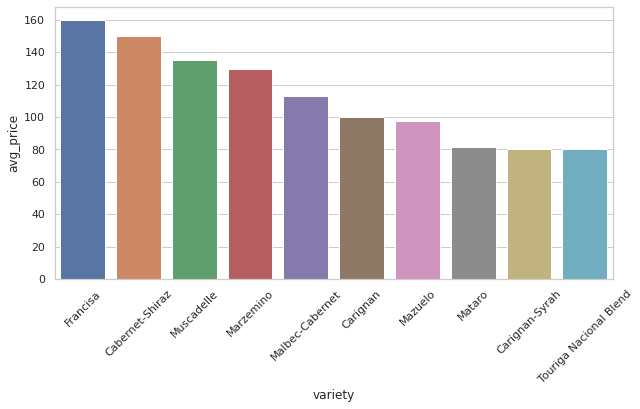

In [9]:
# Самые дорогие сорта в среднем

variety_top_price_mean = df.groupby('variety', as_index=False) \
                            .agg({'price': 'mean'}) \
                            .rename(columns={'price': 'avg_price'}) \
                            .sort_values('avg_price', ascending=False) \
                            .head(10)

ax = sns.barplot(x='variety', y='avg_price', data=variety_top_price_mean);
plt.setp(ax.get_xticklabels(), rotation=45);

In [10]:
top_varieties.merge(variety_top_price_mean, on='variety')

# Мы видим, что два сорта входят в топ-10 как по цене, так и по оценкам

,variety,points,avg_price
0,Cabernet-Shiraz,96.00,150.0
1,Muscadelle,93.25,135.0


In [11]:
# Аномально (за пределами 99% интервала) дорогие вина

st.norm.interval(0.99, loc=df.price.median(), scale=np.std(df.price))

(-64.43467045636916, 124.43467045636916)

In [12]:
most_expensive_wines = df.query('price > 124')

In [13]:
# Количество вин в каждой стране

wine_distribution_by_country = df.groupby('country', as_index=False) \
    .agg({'winery': 'count'}) \
    .rename(columns={'winery': 'country_count'}) \
    .sort_values('country_count', ascending=False) \

In [14]:
# Самый популярный сорт в каждой стране

df_prepared = df.groupby(['country', 'variety'], as_index=False) \
    .agg({'winery': 'count'}) \
    .pivot(index='country', columns='variety', values='winery').reset_index().fillna(0) \

df_country = df_prepared.country

del df_prepared['country']

df_variety = df_prepared.idxmax(axis=1)

popular_variety_country = pd.concat([df_country, df_variety], axis=1)
popular_variety_country = popular_variety_country.rename(columns={0: 'popular_variety'})

In [15]:
# Топ-10 виноделен по средним оценкам

top_wineries = df.groupby('winery', as_index=False) \
    .agg({'points': 'mean'}) \
    .rename(columns={'points':'avg_points'}) \
    .sort_values('avg_points', ascending=False) \
    .head(10)

In [16]:
# Самый продаваемый сорт у каждой винодельни

df_winery_varieties = df.groupby(['winery', 'variety'], as_index=False) \
    .agg({'country': 'count'}) \
    .pivot(index='winery', columns='variety', values='country').reset_index().fillna(0)

df_wineries = df_winery_varieties.winery
del df_winery_varieties['winery']
df_varieties = df_winery_varieties.idxmax(axis=1)

most_popular_variety_by_winery = pd.concat([df_wineries, df_varieties], axis=1)
most_popular_variety_by_winery = most_popular_variety_by_winery.rename(columns={0: 'top_variety'})

In [17]:
# Количество виноделен и уникальных сортов в каждой стране 

wineries_and_varieties_per_country = df.groupby('country', as_index=False) \
    .agg({'winery': 'nunique', 'variety': 'nunique'}) \
    .rename(columns={'winery': 'unique_wineries', 'variety': 'unique_varieties'}) 

# Среднее кол-во сортов на винодельню

wineries_and_varieties_per_country['variety_per_winery_avg'] = wineries_and_varieties_per_country.unique_wineries \
                                    / wineries_and_varieties_per_country.unique_varieties

In [34]:
# Самый частый год розлива вин по странам 

df_year = df
df_year['year'] = df_year['title'].str.extract("(\d{4})")
df_year = df_year.dropna()
df_year['year'] = df_year.year.astype('int')

df_mode_year_country = df_year.groupby('country', as_index=False) \
    .agg({'year': lambda x:st.mode(x)[0]})

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,country,year
0,Argentina,2012
1,Australia,2013
2,Canada,2012
3,France,2014
4,Italy,2012
5,Spain,2011
6,US,2013


In [28]:
# Cамый популярный год розлива вин по сортам

df_year_variety = df_year.groupby(['variety', 'year'], as_index=False) \
    .agg({'country': 'count'}) \
    .pivot(index='variety', columns='year', values='country').reset_index().fillna(0)

df_var = df_year_variety.variety

del df_year_variety['variety']

df_years = df_year_variety.idxmax(axis=1)

top_year_variety = pd.concat([df_var, df_years], axis=1)
top_year_variety = top_year_variety.rename(columns = {0: 'top_year'})

,variety,top_year
0,Abouriou,2012
1,Aglianico,2012
2,Airen,2009
3,Albana,2015
4,Albanello,2012
...,...,...
408,White Riesling,1998
409,Xarel-lo,2015
410,Zibibbo,2013
411,Zinfandel,2013


In [19]:
# Есть ли корреляция между стоимостью вина и поставленной оценкой?

st.spearmanr(df.price, df.points)

SpearmanrResult(correlation=0.6106599247287493, pvalue=0.0)

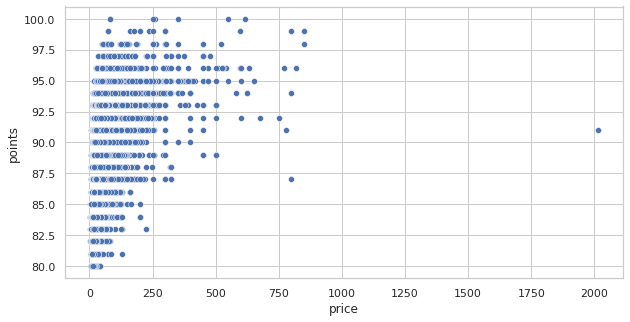

In [20]:
# Согласно шкале Чеддока, корреляция заметная (0.5 - 0.7), а уровень значимости < 0.05 => статистически значимая разница
# Взглянем на график

sns.scatterplot(x='price', y='points', data=df);

# Получается странный график 
# Посмотрим на распределение цен

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


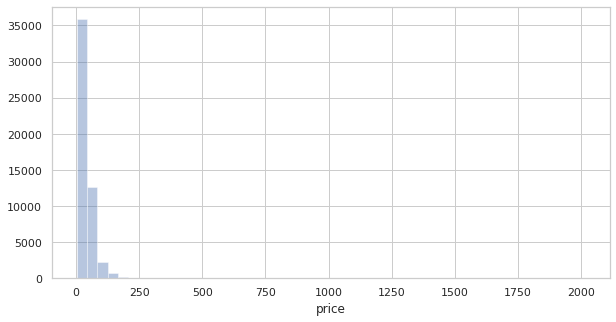

In [22]:
# Распределение цен вин

sns.distplot(df.price, kde=False);

# Распределение слабо напоминает нормальное - очень много вин определённой ценовой категории

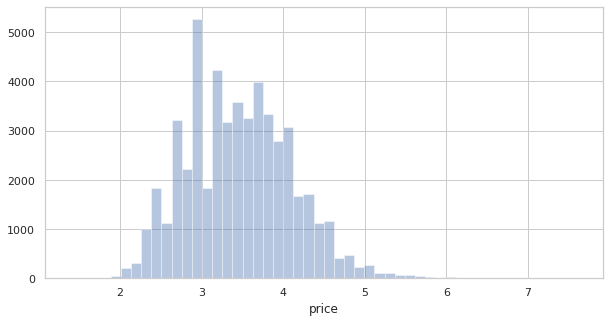

In [23]:
# Прологарфимируем значение
# Выходит более подходящий график

sns.distplot(np.log(df.price), kde=False);

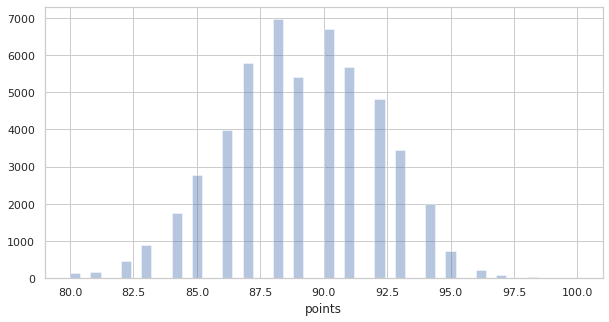

In [24]:
# Распределение поставленных оценок

sns.distplot(df.points, kde=False);

# Более-менее нормальное, но центральные значения проседают

Text(0, 0.5, 'Оценка')

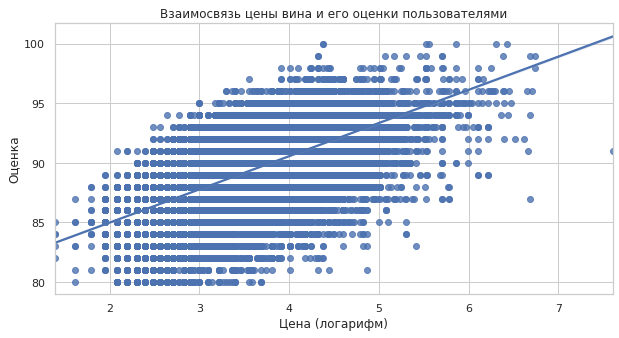

In [60]:
# Добавим в датасет пролагорифмированные значения и построим график

df['price_log'] = np.log(df.price)
df['points_log'] = np.log(df.points)


sns.regplot(x='price_log', y='points', data=df)
plt.title('Взаимосвязь цены вина и его оценки пользователями')
plt.xlabel('Цена (логарифм)')
plt.ylabel('Оценка')

In [26]:
# Напишем уравнение линейной регресии 
# Y = b0 + b1*X + e

In [27]:
results = smf.ols('points ~ price', df).fit()
print(results.summary())

# Модель объясняет всего 20 процентов изменичивости (R-squared)

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                 1.340e+04
Date:                Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                        09:02:55   Log-Likelihood:            -1.2457e+05
No. Observations:               52106   AIC:                         2.491e+05
Df Residuals:                   52104   BIC:                         2.492e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     87.5785      0.017   5129.077      0.0

In [28]:
# Уравнение принимает следующий вид: points = 87.5785 + 0.0366 * price + standardized_residuals

In [21]:
# Проверяем по условиям: 
# 1. Связь линейна и монотонна (сделано выше)
# 2. Остатки распределены нормальным образом
# 3. Нет выбросов
# 4. Дисперсия ЗП однородна на всех уровнях НП (гомоскедастичность)

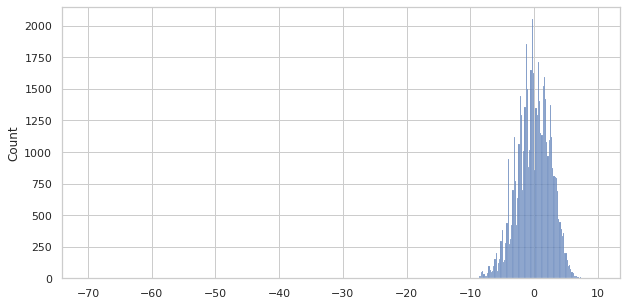

In [29]:
# Посчитаем остатки уравнения регрессии

sns.histplot(results.resid)

# Остатки с натяжкой можно назвать нормальными 

In [30]:
residuals = results.resid
fitted_value = results.fittedvalues
stand_resids = results.resid_pearson
influence = results.get_influence()
leverage = influence.hat_matrix_diag

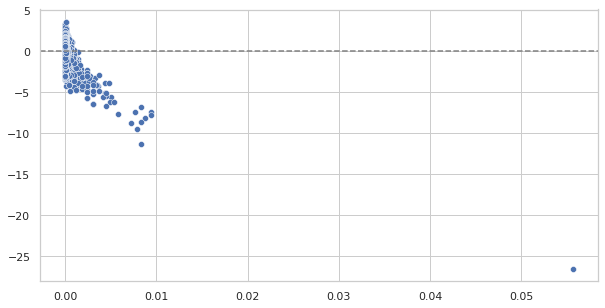

In [31]:
# scale-location plot для проверки на гомоскедатичность

ax = sns.scatterplot(x=leverage, y=stand_resids);
ax.axhline(y=0, color='grey', linestyle='dashed')

# Возможно, присутствует граница, которую значения не могут перейти.
# Скорее всего, это вызвано тем, что минимальная оценка вина - 80
# Мы не можем сказать, что дисперсия ЗП однородна на всех уровнях НП

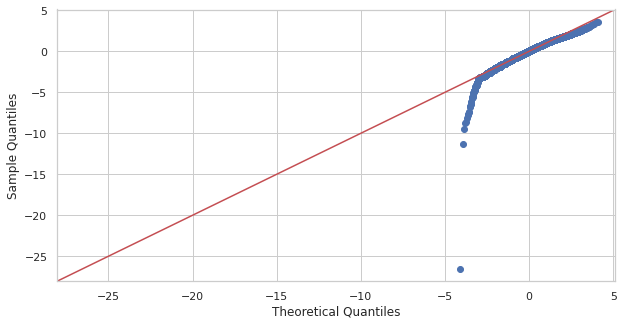

In [32]:
# Проверка на нормальность распределения результатов

sm.qqplot(residuals, fit=True, line='45', c='#4C72B0');

# Есть довольно значимые отклонения по краям, особенно с левой стороны
# Распределение с трудом можно назвать нормальным

In [33]:
# Вывод: Мы увидели, что несмотря на заметную корреляцию в 0.6 между ценой и оценкой вина,
# качество нашей регрессионной модели довольно низкое - 
# она объясняет только 20% изменчивости (при P>|t| = 0). Проверив нашу модель по условиям применения, мы увидели, что:

# - связь линейна;
# - остатки распределены относительно нормальным образом;
# - присутствуют значительные выбросы;
# - модель гетероскедатична (вероятно, роль играет порог минимальной оценки).


# Таким образом, мы не можем сказать, что есть какая-либо значимая связь между оценкой и ценой.
# Для более точной модели требуется дополнительное преобразование данных